In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt


In [15]:
btc = pd.read_csv("BTC-USD.csv")
btc['Valor Promedio'] = (btc["Low"] + btc["High"])/2
btc = btc.groupby(pd.PeriodIndex(btc['Date'], freq="M"))['Valor Promedio'].mean().reset_index()
busquedas = pd.read_csv("Busquedas en google Blockchain.csv", parse_dates=["Semana"])
busquedas = busquedas.groupby(pd.PeriodIndex(busquedas['Semana'], freq="M"))['blockchain: (Todo el mundo)'].mean().reset_index()
data = btc.merge(busquedas, right_on='Semana', left_on='Date' , how='inner')
data["year"] = data["Semana"].dt.year
data = data.rename(columns={"blockchain: (Todo el mundo)": "Busquedas Blockchain", "B": "c"})
data = data.astype({'year':object})
data = data[['year',"Busquedas Blockchain",'Valor Promedio']]
data.head()


,year,Busquedas Blockchain,Valor Promedio
0,2018,100.00,13557.345215
1,2018,82.00,9003.379883
2,2018,75.75,9194.014892
3,2018,69.40,8136.095215
4,2018,69.75,8527.590088


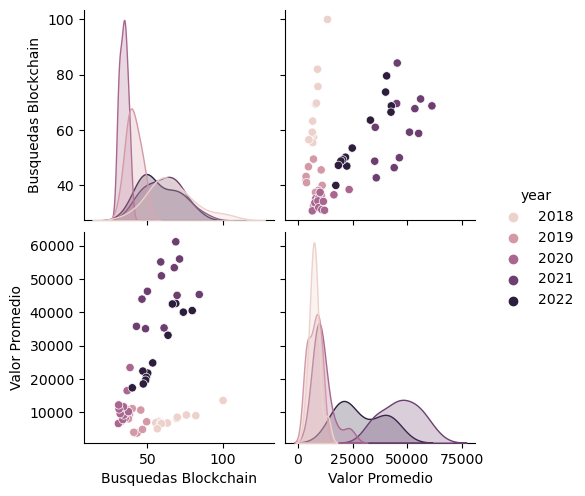

In [16]:
sns.pairplot(data,hue='year')

Text(0.5, 1.0, 'Valor de BTC vs Búsquedas de Google')

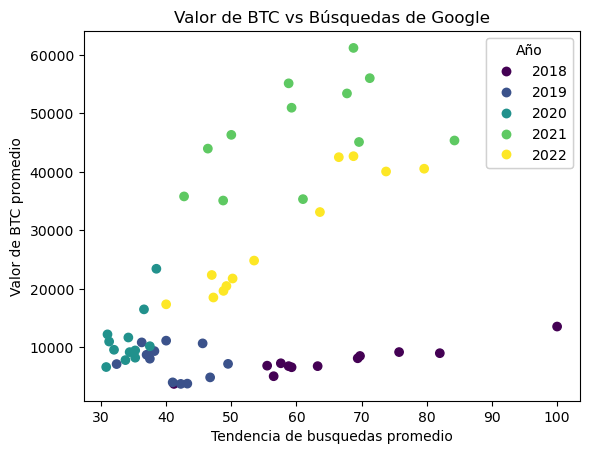

In [17]:
fig, ax = plt.subplots()
scatter = ax.scatter(data['Busquedas Blockchain'], data['Valor Promedio'],c=data["year"])
plt.xlabel("Tendencia de busquedas promedio")
plt.ylabel("Valor de BTC promedio")

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Año")
ax.add_artist(legend1)

plt.title("Valor de BTC vs Búsquedas de Google")

Vemos que en general existe una tendencia lineal entre busquedas de blockchain y el valor del bitcoin, en especial con el año 2018 y 2022. Generamos entonces un modelo de regression lineal multivariable

In [18]:
transformer = make_column_transformer(
    (OneHotEncoder(), ['year']),
    remainder='passthrough')

transformed = transformer.fit_transform(data)
transformer.get_feature_names_out()

transformed_df = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names_out()
)
transformed_df

,onehotencoder__year_2018,onehotencoder__year_2019,onehotencoder__year_2020,onehotencoder__year_2021,onehotencoder__year_2022,remainder__Busquedas Blockchain,remainder__Valor Promedio
0,1.0,0.0,0.0,0.0,0.0,100.00,13557.345215
1,1.0,0.0,0.0,0.0,0.0,82.00,9003.379883
2,1.0,0.0,0.0,0.0,0.0,75.75,9194.014892
3,1.0,0.0,0.0,0.0,0.0,69.40,8136.095215
4,1.0,0.0,0.0,0.0,0.0,69.75,8527.590088
5,1.0,0.0,0.0,0.0,0.0,63.25,6790.650147
6,1.0,0.0,0.0,0.0,0.0,57.60,7280.344726
7,1.0,0.0,0.0,0.0,0.0,55.50,6870.044922
8,1.0,0.0,0.0,0.0,0.0,58.80,6792.975098
9,1.0,0.0,0.0,0.0,0.0,59.25,6600.765137


In [19]:
y = transformed_df["remainder__Valor Promedio"]
transformed_df = transformed_df.drop(columns="remainder__Valor Promedio")
x_train, x_test, y_train, y_test = train_test_split(transformed_df,
                                                    y, test_size=0.2, random_state=1234)
modelo = LinearRegression()
modelo.fit(x_train,y_train)

LinearRegression()

In [20]:
score = modelo.score(x_test, y_test)
y_pred = modelo.predict(x_test)
print("R-squared: ", score)
print("b: ", modelo.intercept_)
print("coeficientes: ", score)

modelo.coef_


R-squared:  0.9148387251341888
b:  1558.5435119054273
coeficientes:  0.9148387251341888


array([-17590.40414455,  -8654.80485298,  -2481.43561756,  22531.06704872,
         6195.57756637,    353.57930774])

## Segundo modelo

In [22]:
# Cargar datos históricos de precios de Bitcoin y volumen de comercio
df = pd.read_csv("BTC-USD.csv")

# Asignar variables independientes y dependiente
X = df[["Volume"]]
y = df["Marketcap"]

# Dividir datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Ajustar modelo de regresión lineal a los datos de entrenamiento
reg = LinearRegression().fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = reg.predict(X_test)

# Evaluar el rendimiento del modelo utilizando una métrica de error


print("Error cuadrático medio: ", mean_squared_error(y_test, y_pred))

print("MAE: ", mean_absolute_error(y_test, y_pred))


print("R2: ", r2_score(y_test, y_pred))


mean_volume = df['Volume'].mean()
mean_marketcap = df['Marketcap'].mean()

print("Promedio del volumen: ",mean_volume)
print("Promedio del marketcap:",mean_marketcap)
corr_matrix = df.corr()

print(corr_matrix)

Error cuadrático medio:  1.5006831788704016e+22
MAE:  60738627856.21987
R2:  0.6719766425797309
Promedio del volumen:  10906334004.866846
Promedio del marketcap: 120876059112.8842
                SNo      High       Low      Open     Close    Volume  \
SNo        1.000000  0.667028  0.671538  0.668551  0.669008  0.718164   
High       0.667028  1.000000  0.998841  0.999442  0.999417  0.810464   
Low        0.671538  0.998841  1.000000  0.998905  0.999291  0.803110   
Open       0.668551  0.999442  0.998905  1.000000  0.998646  0.808439   
Close      0.669008  0.999417  0.999291  0.998646  1.000000  0.807388   
Volume     0.718164  0.810464  0.803110  0.808439  0.807388  1.000000   
Marketcap  0.664713  0.999094  0.999072  0.998382  0.999709  0.809156   

           Marketcap  
SNo         0.664713  
High        0.999094  
Low         0.999072  
Open        0.998382  
Close       0.999709  
Volume      0.809156  
Marketcap   1.000000  


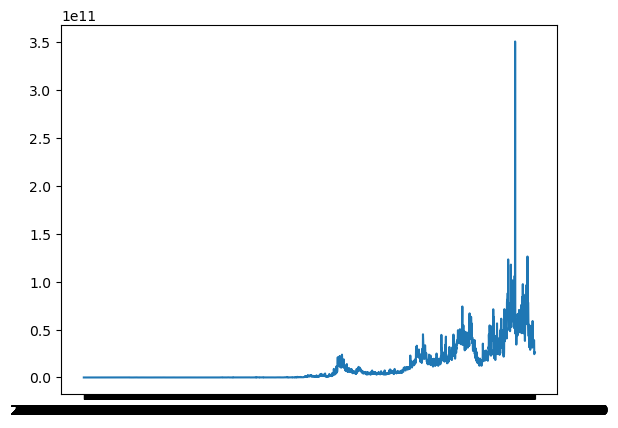

In [23]:
x1 = df['Date']
y1 = df['Volume']
z1= df['Marketcap']
# Graficar los datos
plt.plot(x1, y1)

plt.show()

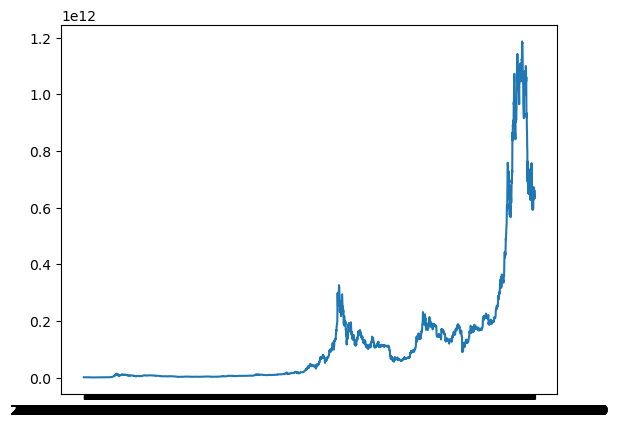

In [24]:
plt.plot(x1, z1)

plt.show()

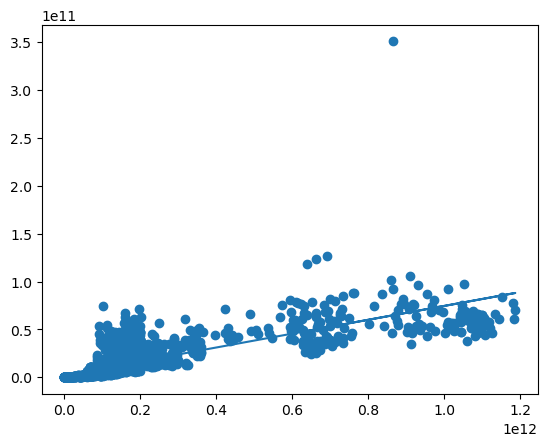

In [25]:
# Crear un gráfico de dispersión de los puntos de datos
plt.scatter(y, X)

# Calcular la línea de regresión
a, b = np.polyfit(y, X, 1)

# Trazar la línea de regresión sobre el gráfico de dispersión
plt.plot(y, a*y + b)

# Mostrar el gráfico
plt.show()